In [10]:
import numpy as np
import librosa
from matplotlib import pyplot as plt
from IPython.display import display, Audio
from glob import glob
import os

from utils import draw_spec, audioshow
from stft import extract_frames, stft, overlapadd, istft, LSEE_MSTFTM, SER, ola_tsm
from tsm import SynchronousOLA, LSEE_TSM

In [11]:
dir_path = "./*.wav"
for i in range(len(glob(dir_path))):
    print(f'[{i:02d}] {os.path.basename(glob(dir_path)[i])}')

[00] sample.wav
[01] sample_long.wav


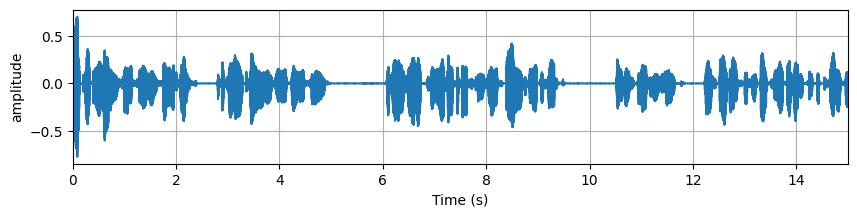

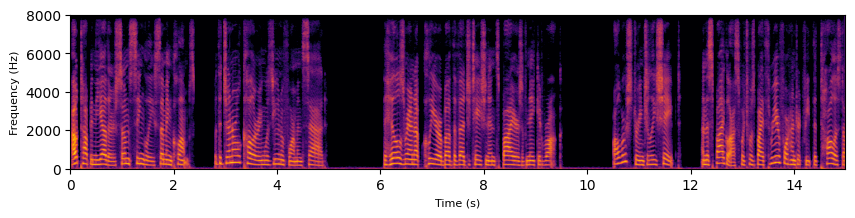

In [14]:
FIGSIZE = (10,2)

index = 1
y, sr = librosa.load(glob(dir_path)[index], sr=16000)

display(Audio(y, rate=sr))
audioshow(y, sr=sr, figsize=FIGSIZE)
_ = draw_spec(y, sr=sr, figsize=FIGSIZE, use_colorbar=False)

## TSM

Final SER after 100 iterations: 11.94 dB
(513, 126)


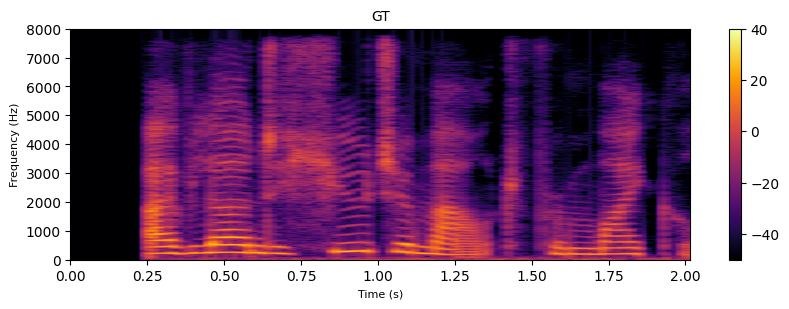

(513, 63)


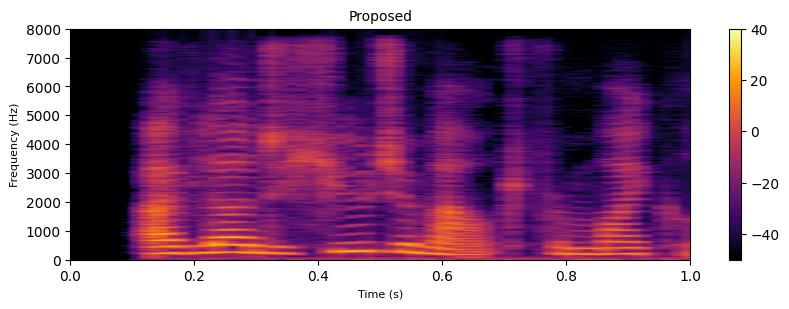

(513, 63)


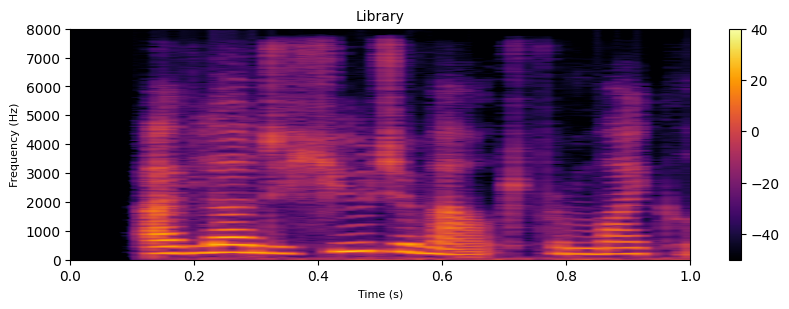

(513, 63)


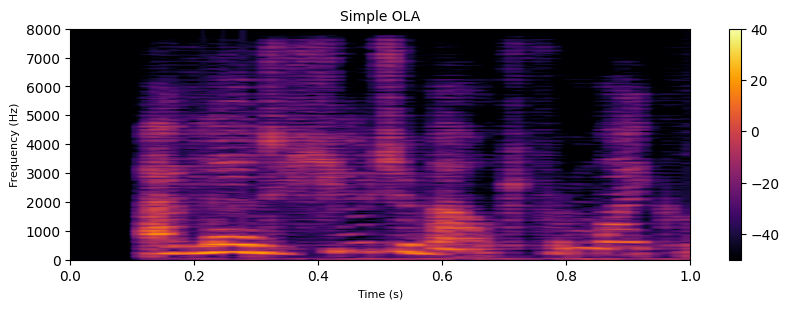

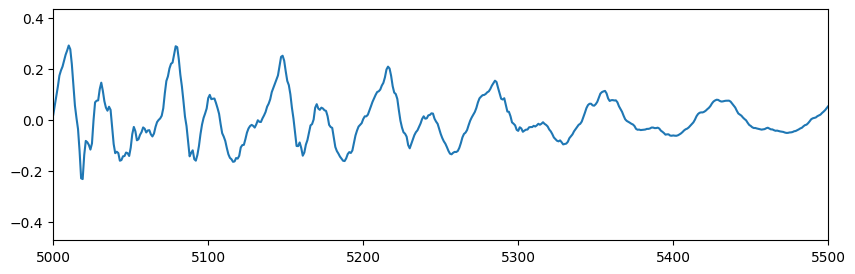

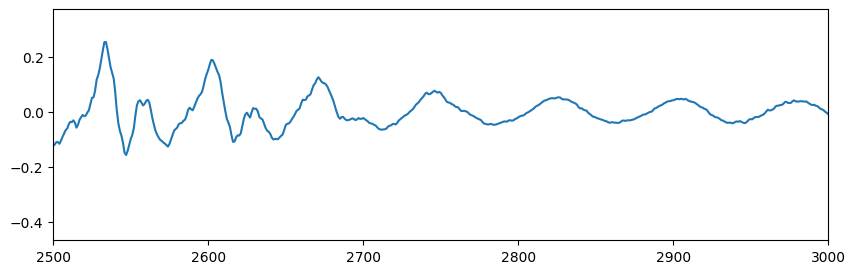

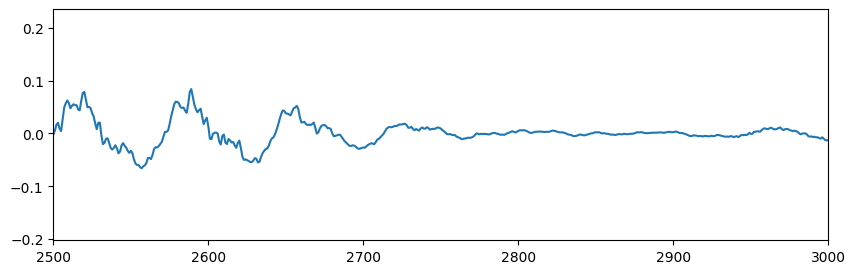

In [4]:
from utils import spec_show
"""
16 khz data
hop_length: 256 (16ms, 75% overlap)
win_length: 1024 (64ms)
"""
RATE= 2
WINLEN = 1024
HOPLEN = 256
NFFT = 1024
FIGSIZE=(10,3)

# proposed
y_tsm = LSEE_TSM(y, rate=RATE, initial='sola', win_length=WINLEN, hop_length=HOPLEN, num_iterations=100, verbose=False)
# library
stftm = np.abs(stft(y, n_fft=NFFT, win_type='hamming', win_length=WINLEN, hop_length=HOPLEN, plot=False))
y_lib = librosa.griffinlim(stftm, n_iter=100, hop_length=int(HOPLEN/RATE), win_length=int(WINLEN), window='hamming')
## simple ola (not in frequency domain)
y_ = ola_tsm(y, win_length=WINLEN, hop_in=HOPLEN, hop_out=int(HOPLEN/RATE))
print(stftm.shape)
spec_show(stftm, sr=sr, figsize=FIGSIZE, title='GT')

## original spectrum w. different scale
# stftm = np.abs(stft(y, n_fft=NFFT, win_type='hamming', win_length=WINLEN, hop_length=int(HOPLEN/RATE), plot=False))
# print(stftm.shape)
# spec_show(stftm, sr=sr, figsize=FIGSIZE, x_extent=2, title='GT (w. hoplen modified)')

## proposed: TSM spectrum
stftm = np.abs(stft(y_tsm, n_fft=NFFT, win_type='hamming', win_length=WINLEN, hop_length=int(HOPLEN), plot=False))
print(stftm.shape)
spec_show(stftm, sr=sr, figsize=FIGSIZE, x_extent=2/RATE, title='Proposed')

## library: TSM spectrum
stftm = np.abs(stft(y_lib, n_fft=NFFT, win_type='hamming', win_length=WINLEN, hop_length=int(HOPLEN), plot=False))
print(stftm.shape)
spec_show(stftm, sr=sr, figsize=FIGSIZE, x_extent=2/RATE, title='Library')

## simple ola: TSM spectrum
stftm = np.abs(stft(y_, n_fft=NFFT, win_type='hamming', win_length=WINLEN, hop_length=int(HOPLEN), plot=False))
print(stftm.shape)
spec_show(stftm, sr=sr, figsize=FIGSIZE, x_extent=2/RATE, title='Simple OLA')

display(Audio(y, rate=sr*RATE))
display(Audio(y_tsm, rate=sr))
display(Audio(y_lib, rate=sr))
display(Audio(y_, rate=sr))

# audioshow(y, sr=sr)
# audioshow(y_tsm, sr=sr)
# audioshow(y_lib, sr=sr)
# audioshow(y_)

plt.figure(figsize=FIGSIZE)
plt.plot(y)
start = 5000
offset = 500
plt.xlim(start,start+offset)
plt.show()
plt.figure(figsize=FIGSIZE)
plt.plot(y_tsm)
plt.xlim(start/RATE,(start+offset)/RATE)
plt.xlim(start/RATE,start/RATE+offset)
plt.show()
plt.figure(figsize=FIGSIZE)
plt.plot(y_)
plt.xlim(start/RATE,(start+offset)/RATE)
plt.xlim(start/RATE,start/RATE+offset)
plt.show()

Final SER after 100 iterations: 17.75 dB


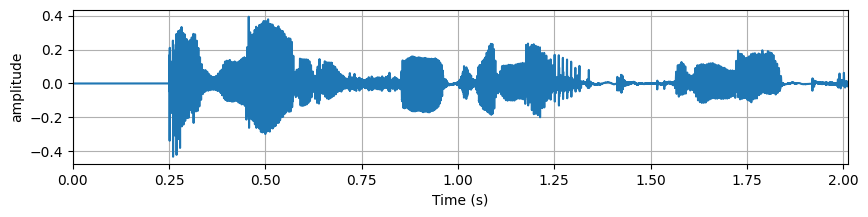

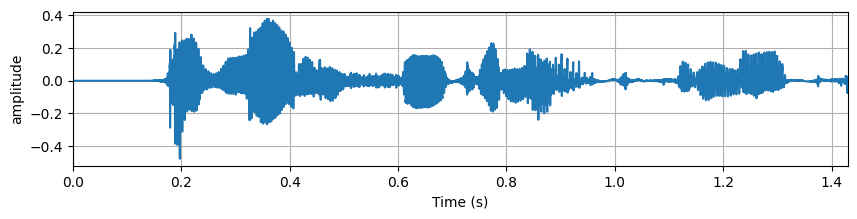

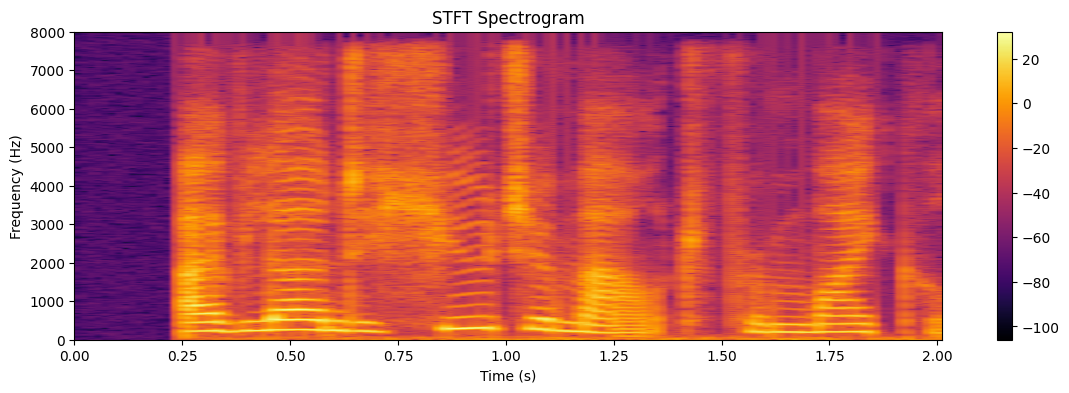

126


In [5]:
from utils import spec_show
"""
16 khz data
hop_length: 256 (16ms, 75% overlap)
win_length: 1024 (64ms)
"""
RATE= 1.4
WINLEN = 1024
HOPLEN = 256
NFFT = 1024
FIGSIZE=(10,2)

# proposed
y_tsm = LSEE_TSM(y, rate=RATE, initial='sola', win_length=WINLEN, hop_length=HOPLEN, num_iterations=100, verbose=False)
# library
audioshow(y, figsize=FIGSIZE)
audioshow(y_tsm, figsize=FIGSIZE)

stftm = np.abs(stft(y, sr=sr, win_length=WINLEN, hop_length=HOPLEN, n_fft=NFFT, 
                    plot=True, cmap='inferno', 
                    vmin=None, vmax=None
                    ))
frames = extract_frames(y, win_length=WINLEN, hop_length=HOPLEN)
print(len(frames)) # 513 x 126

# f = stftm[:,32]
# print(stftm.shape)
# f = stftm[:,32]
# plt.figure(figsize=FIGSIZE)
# plt.plot(20*np.log10(np.abs(f)))
# plt.show()

(513, 126)
(32192,) (42752,)


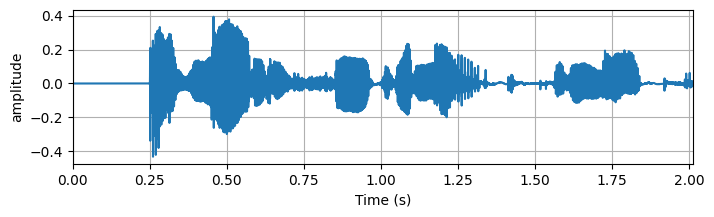

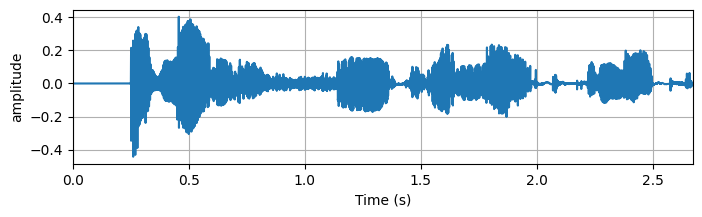

In [6]:
def overlapadd(frames, win_length, hop_lengths, frame_range, win_type='hann', griffin=True):
    """
    Modified OLA process with variable hop lengths for specific frame ranges.
    input: 
        frames: frame list with [NumFrames]
        hop_lengths: (Sa, Ss) tuple representing default and modified hop lengths
        frame_range: (start_idx, end_idx) where Ss is applied
        win_type: Window array or string type of window
    output:
        y: Reconstructed waveform using modified OLA.
    """
    num_frames = len(frames)
    Sa, Ss = hop_lengths
    siglen = win_length + sum(Ss if frame_range[0] <= idx <= frame_range[1] else Sa for idx in range(num_frames))
    y = np.zeros(siglen)
    window_sum = np.zeros(siglen)
    
    # Generate window
    if isinstance(win_type, str):
        try:
            window = librosa.filters.get_window(win_type, win_length)
        except ValueError:
            raise ValueError("Unsupported window type!")
    else:
        window = win_type  # Assume win_type is already an array with proper padding
    
    current_position = 0  # Track the cumulative start position
    for frame_idx in range(num_frames):
        # Choose hop length based on frame range
        hop_length = Ss if frame_range[0] <= frame_idx <= frame_range[1] else Sa
        # print(frame_idx, hop_length)
        start = current_position
        frame = frames[frame_idx]
        
        if griffin:
            y[start:start + win_length] += frame * window
            window_sum[start:start + win_length] += window ** 2
        else:
            y[start:start + win_length] += frame
            window_sum[start:start + win_length] += window            
        # Update the current position based on the hop length
        current_position += hop_length
    
    # Normalize by window overlap factor
    y /= np.where(window_sum > 1e-10, window_sum, 1e-10)

    # Crop to remove paddings (center-based STFT)
    y = y[win_length // 2:-win_length // 2]
    window_sum = window_sum[win_length // 2:-win_length // 2]
    return y

def istft(Y_w, win_length, hop_lengths, n_fft, frame_range, win_type='hann', griffin=True):
    """
    Modified ISTFT to handle variable hop lengths for specific frame ranges.
    ** Returns:
        y_buffer: Reconstructed time-domain signal
    """
    if not n_fft:
        n_fft = win_length  # Default to win_length if n_fft is not provided
        
    if win_length < min(hop_lengths):
        raise ValueError(f"win_length ({win_length}) must be greater than or equal to the smallest hop_length ({min(hop_lengths)})")
    if n_fft < win_length:
        raise ValueError(f"n_fft ({n_fft}) must be greater than or equal to win_length ({win_length})")

    # Generate window with padding if win_length < n_fft
    try:
        window = librosa.filters.get_window(win_type, win_length)
    except ValueError:
        raise ValueError("Unsupported window type!")
    padlen = n_fft - win_length
    padded_window = np.pad(window, (padlen // 2, padlen // 2), mode='constant')

    # Reconstruct Y to get full spectrum in frequency axis
    Y_flip = np.flipud(Y_w)[1:-1]
    Y_w = np.concatenate((Y_w, np.conj(Y_flip)), axis=0)  # Note that phase is odd
    
    num_frames = Y_w.shape[1]
    frames = []

    # Calculate each frame by inverse FFT
    for frame_idx in range(num_frames):
        frame = np.real(np.fft.ifft(Y_w[:, frame_idx]))  # Inverse FFT
        frames.append(frame)
    
    # Modified OLA with variable hop lengths
    y_buffer = overlapadd(frames, win_length=win_length, hop_lengths=hop_lengths, 
                          frame_range=frame_range, win_type=padded_window, griffin=griffin)
    return y_buffer

# Example parameters
WINLEN = 1024
NFFT = 1024
HOPLEN = 256  # Default hop length
RATE = 0.5
Ss = int(HOPLEN/RATE)  # Modified hop length (faster)
frame_range = (35, 75)  # Apply Ss for frames 10 to 15
win_type = 'hann'

y,sr = librosa.load(glob(dir_path)[0], sr=None)
Y_w = stft(y, win_length=WINLEN, hop_length=HOPLEN, n_fft=NFFT, )

# Call the modified ISTFT
y_reconstructed = istft(Y_w, win_length=WINLEN, hop_lengths=(HOPLEN, Ss), n_fft=NFFT, 
                         frame_range=frame_range, win_type=win_type)

# print(y_reconstructed[5])

print(Y_w.shape)
print(y.shape, y_reconstructed.shape)

audioshow(y)
audioshow(y_reconstructed)
display(Audio(y, rate=sr))
display(Audio(y_reconstructed, rate=sr))


32192
32192
tsm 44032 orig 32192
1 It / (513, 126) STFT shape / (513, 126) ORIG shape
tsm 44032 orig 32192
2 It / (513, 126) STFT shape / (513, 126) ORIG shape
tsm 44032 orig 32192
3 It / (513, 126) STFT shape / (513, 126) ORIG shape
tsm 44032 orig 32192
4 It / (513, 126) STFT shape / (513, 126) ORIG shape
tsm 44032 orig 32192
5 It / (513, 126) STFT shape / (513, 126) ORIG shape
tsm 44032 orig 32192
6 It / (513, 126) STFT shape / (513, 126) ORIG shape
tsm 44032 orig 32192
7 It / (513, 126) STFT shape / (513, 126) ORIG shape
tsm 44032 orig 32192
8 It / (513, 126) STFT shape / (513, 126) ORIG shape
tsm 44032 orig 32192
9 It / (513, 126) STFT shape / (513, 126) ORIG shape
tsm 44032 orig 32192
Final SER after 10 iterations: 15.17 dB


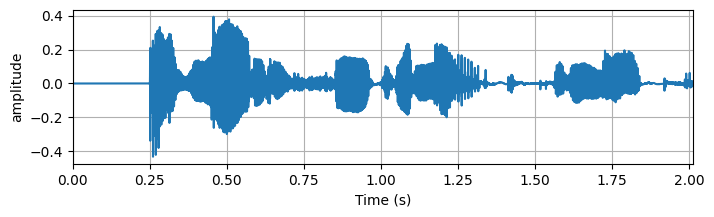

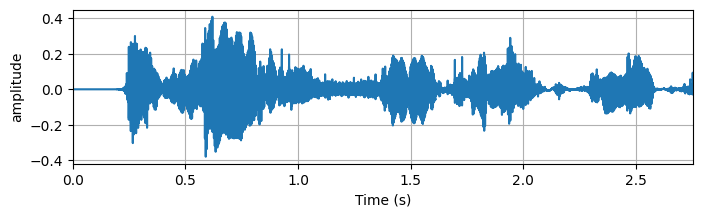

In [7]:


def mod_LSEE_TSM(y, rate=2, hop_length=256, win_length=512, win_type='hamming', num_iterations=50, 
                 frame_range=frame_range,
             verbose=True, griffin=True, initial='gaussian', return_ser=False):
    from fractions import Fraction
    """
    Time-Scale Modification using LSEE-MSTFTM for phase reconstruction.
    ** Inputs:
        y: Original input signal
        rate: Time-scaling factor (e.g., rate=2 means 2x speed-up)
        hop_length: Hop length for the original signal STFT
        win_length: Window length
        win_type: Window type (default 'hamming')
        num_iterations: Number of iterations for phase reconstruction
        verbose: Print SER at each iteration
        initial: ['gaussian', 'sola', 'zero_phase']
    ** Returns:
        x_reconstructed: Time-scaled and phase-reconstructed signal
    """
    n_fft = win_length
    Sa = hop_length 
    Ss = int(np.round(Sa / rate))  

    # Length adjustment
    frac_rate = Fraction(rate).limit_denominator()
    n = frac_rate.numerator
    y_len = (len(y) // n) * n 
    print(y_len)
    y = y[:y_len]
    
    # STFTM of original
    Y = np.abs(stft(y, n_fft=n_fft, win_type=win_type, win_length=win_length, hop_length=Sa, plot=False))
    if verbose: print(f"STFT of original signal (shape): {Y.shape}") 
    
    # Initial estmiate of TSM signal
    x_len = int(len(y) / rate)
    if initial == 'gaussian':
        x_initial = np.random.normal(0, 1, x_len)  
    elif initial  == 'sola':
        ################################### Key implementations ###################################
        frames = extract_frames(y, win_type=win_type, win_length=win_length, hop_length=Sa)
        x_initial = SynchronousOLA(frames, win_length=win_length, hop_length=Ss, win_type=win_type, visualize=verbose)
        ################################### Key implementations ###################################
    elif initial == 'zero_phase':
        X = Y
    else: 
        raise ValueError(f"Unsupported initial method: {initial}")
    
    ser_list = []
    for i in range(num_iterations):
        # Compute STFT of the current time-domain signal x
        if initial != 'zero_phase' or i > 0:
            X = custom_stft(x_initial, n_fft=n_fft, win_length=win_length, hop_lengths=(Sa, Ss),
                            frame_range=frame_range, win_type=win_type)
            print(f'{i} It / {X.shape} STFT shape / {Y.shape} ORIG shape',)
        # Replace magnitude into STFTM (Y)
        if X.shape[1] == Y.shape[1]:
            X_phase = np.angle(X)
            X_new = Y * np.exp(1j * X_phase)
        else:
            raise ValueError(f"Mismatch in STFT frame count. {X.shape[1]}<>{Y.shape[1]} Please adjust the rate or signal length.")

        # Calculate SER (Spectral Error Ratio)
        current_magnitude = np.abs(X)
        ser_value = SER(Y, current_magnitude)
        ser_list.append(ser_value)
        if verbose:
            print(f"Iteration {i}/{num_iterations}, SER: {ser_value:.2f} dB")

        # ISTFT (OLA) and update the estimate
        x_initial = istft(X_new, win_length=win_length, hop_lengths=(Sa, Ss), n_fft=n_fft,
                        frame_range=frame_range, win_type=win_type, griffin=griffin)
        print('tsm', len(x_initial), 'orig', len(y))
        # x_initial = x_initial[:len(y)]
        
    final_ser_value = SER(Y, np.abs(custom_stft(x_initial, n_fft=n_fft, win_length=win_length, hop_lengths=(Sa, Ss),
                            frame_range=frame_range, win_type=win_type)))
    print(f"Final SER after {num_iterations} iterations: {final_ser_value:.2f} dB")
    ser_list.append(final_ser_value)

    if return_ser:
        plt.plot(ser_list)
        plt.title("SER over Iterations")
        plt.xlabel("Iteration")
        plt.ylabel("SER (dB)")
        plt.show()
        return x_initial, ser_list
    else:
        return x_initial


def custom_stft(y, sr=16000, win_type='hamming', win_length=320, hop_lengths=(160, 320), 
                frame_range=(10, 20), n_fft=None, pad_mode='constant'):
    """
    Compute STFT with variable hop lengths for specific frame ranges.
    ** Parameters:
        y: Input signal
        hop_lengths: Tuple (Sa, Ss) for default and modified hop lengths
        frame_range: Tuple (start_idx, end_idx) for frames where Ss is applied
    ** Returns:
        spec: Complex STFT (NFFT//2+1 x Frames)
    """
    if not n_fft:
        n_fft = win_length
    
    if win_length < min(hop_lengths):
        raise ValueError(f"win_length ({win_length}) must be greater than or equal to the smallest hop_length ({min(hop_lengths)})")
    if n_fft < win_length:
        raise ValueError(f"n_fft ({n_fft}) must be greater than or equal to win_length ({win_length})")
    
    y = np.pad(y, (n_fft//2, n_fft//2), mode=pad_mode, constant_values=0)  # Padding
    siglen_pad = len(y)  # Length of the padded signal

    # Generate window
    try:
        window = librosa.filters.get_window(win_type, win_length)
    except ValueError:
        raise ValueError("Unsupported window type!")

    # Initialize variables
    spec = []
    centers = []
    current_center = n_fft // 2  # Start from the center
    Sa, Ss = hop_lengths

    frame_idx = 0
    while current_center + n_fft // 2 < siglen_pad:
        centers.append(current_center)

        # Determine hop length for the next frame
        hop_length = Ss if frame_range[0] <= frame_idx <= frame_range[1] else Sa
        current_center += hop_length
        frame_idx += 1
        
    tt = range(n_fft//2, siglen_pad, Sa)
    ttt = centers
    # print(len(tt), len(ttt))
    
    # Process frames
    for center in centers:
        start = center - win_length // 2
        end = center + win_length // 2

        if end > siglen_pad:  # End condition
            break

        frame = y[start:end]
        frame = frame * window

        # Zero-pad to match n_fft
        padlen = n_fft - len(frame)
        frame = np.pad(frame, pad_width=[padlen // 2, padlen // 2], mode='constant')

        # Compute FFT and append to the spectrogram
        frame_fft = np.fft.fft(frame)[:n_fft // 2 + 1]
        spec.append(frame_fft)

    spec = np.array(spec).T  # [freq x timeframe]
    return spec 

# Example parameters
WINLEN = 1024
NFFT = 1024
HOPLEN = 256  # Default hop length
RATE = 0.5
Ss = int(HOPLEN/RATE)  # Modified hop length (faster)
frame_range = (35, 95)  # Apply Ss for frames 10 to 15
win_type = 'hann'

y,sr = librosa.load(glob(dir_path)[0], sr=None)
Y_w = stft(y, win_length=WINLEN, hop_length=HOPLEN, n_fft=NFFT, )
print(len(y))

y_reconstructed = mod_LSEE_TSM(y,rate=RATE,hop_length=HOPLEN, win_length=WINLEN, frame_range=(20,65), 
                               num_iterations=10, initial='zero_phase', verbose=False)
audioshow(y)
audioshow(y_reconstructed)
display(Audio(y, rate=sr))
display(Audio(y_reconstructed, rate=sr))

STFT of original signal (shape): (513, 126)
Original signal length: 32192, Reconstructed signal length: 34304


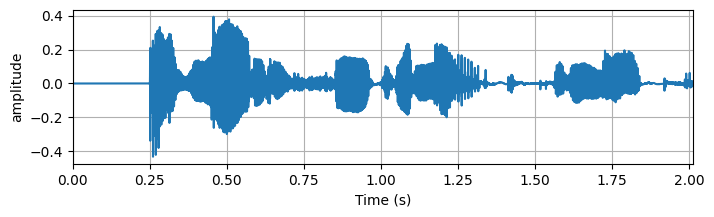

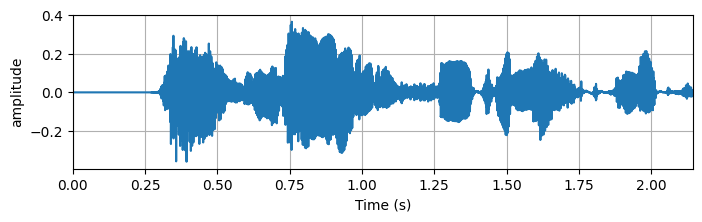

In [9]:
from tsm_selective_multi import mod_LSEE_TSM

# Example parameters
WINLEN = 1024
HOPLEN = 256  # Default hop length
RATE = 0.5
FRAME_RANGES = [(10, 35),  (85, 120)]  # Multiple frame ranges
RATE_RANGES = [0.5, 2]  # Rates for frame ranges
NUM_ITERATIONS = 50
INITIAL_METHOD = 'gaussian'

VERBOSE = True

# Load audio
y, sr = librosa.load(glob(dir_path)[0], sr=None)

# Perform TSM with variable rates
y_reconstructed = mod_LSEE_TSM(
    y, rate=RATE, win_length=WINLEN, frame_ranges=FRAME_RANGES, 
    rate_ranges=RATE_RANGES, num_iterations=NUM_ITERATIONS, initial=INITIAL_METHOD, 
    win_type='hann', verbose=VERBOSE
)

# Display results
print(f"Original signal length: {len(y)}, Reconstructed signal length: {len(y_reconstructed)}")
audioshow(y)
audioshow(y_reconstructed)
display(Audio(y, rate=sr))
display(Audio(y_reconstructed, rate=sr))